In [18]:
products = []

In [19]:
train_data = [product.get('detail_image_url_1') for product in products]
category_small_codes = [category_small_code for product in products for category_small_code in
                        product.get('category_small_code')]
category_small_names = [product.get('category_small_name') for product in products]

In [20]:
labels = list(dict.fromkeys(category_small_codes))
label_dict = {code: {'label': labels.index(code), 'category_name': name} for code, name in zip(category_small_codes, category_small_names)}
label_dict

{275101104: {'label': 0, 'category_name': ['비니']},
 272103108: {'label': 1, 'category_name': ['후디']},
 268105106: {'label': 2, 'category_name': ['크루넥']},
 268103105: {'label': 3, 'category_name': ['후디']}}

In [21]:
images = [product['detail_image_url_1'] for product in products]
labels = [label_dict[product['category_small_code'][0]]['label'] for product in products]

In [22]:
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torchvision import transforms
from PIL import Image
from io import BytesIO
import requests


class CustomImageDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_url = self.data[idx]
        response = requests.get(image_url)
        image = Image.open(BytesIO(response.content)).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return {"image": image, "label": label}


model_name = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(label_dict.keys()))

train_data = [product['detail_image_url_1'] for product in products]
train_labels = [label_dict[product['category_small_code'][0]]['label'] for product in products]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = CustomImageDataset(data=train_data, labels=train_labels, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 30

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        outputs = model(pixel_values=images, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/30, Loss: 1.3669291734695435
Epoch 2/30, Loss: 1.0631695985794067
Epoch 3/30, Loss: 1.0520095825195312
Epoch 4/30, Loss: 0.8950668573379517
Epoch 5/30, Loss: 0.8059147000312805
Epoch 6/30, Loss: 0.7390390634536743
Epoch 7/30, Loss: 0.6826351881027222
Epoch 8/30, Loss: 0.8086088299751282
Epoch 9/30, Loss: 0.5317108631134033
Epoch 10/30, Loss: 0.6699309349060059
Epoch 11/30, Loss: 0.5989297032356262
Epoch 12/30, Loss: 0.5061862468719482
Epoch 13/30, Loss: 0.44186729192733765
Epoch 14/30, Loss: 0.3878498673439026
Epoch 15/30, Loss: 0.4999534785747528
Epoch 16/30, Loss: 0.3583860695362091
Epoch 17/30, Loss: 0.33021119236946106
Epoch 18/30, Loss: 0.31231051683425903
Epoch 19/30, Loss: 0.28276026248931885
Epoch 20/30, Loss: 0.26980599761009216
Epoch 21/30, Loss: 0.2735942006111145
Epoch 22/30, Loss: 0.24982556700706482
Epoch 23/30, Loss: 0.22186079621315002
Epoch 24/30, Loss: 0.2867031991481781
Epoch 25/30, Loss: 0.2143251746892929
Epoch 26/30, Loss: 0.2727072536945343
Epoch 27/30, L

In [23]:
def predict(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert("RGB")

    inputs = feature_extractor(images=image, return_tensors="pt")

    with torch.no_grad():
        logits = model(**inputs).logits

    predicted_label = logits.argmax(-1).item()

    for key in label_dict.keys():
        if label_dict[key].get('label') == predicted_label:
            print(f"predict: {label_dict[key].get('category_name')[0]}")

    image = image.resize((244, 244))
    display(image)

predict: 후디


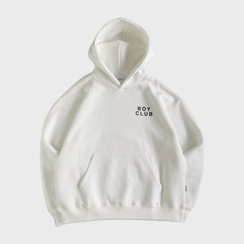

In [25]:
predict("")